# Monetary growth
This notebook has the following goals:
- To show the differences in the growth of the quantity of money in different economies.
- To establish a relationship between growth of the quantity of money, velocity of money and inflation.
The following monetary areas will be studied: the United States, the euro area, Switzerland, the United Kingdom and Japan.

In [57]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
from typing import Final, Literal

from utils import plot_recessions

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

PLOTS_PATH: Final[str] = "figures"

In [58]:
df_us = pd.read_pickle("data/us.pickle")
df_eu = pd.read_pickle("data/eu.pickle")
df_ch = pd.read_pickle("data/ch.pickle")
df_uk = pd.read_pickle("data/uk.pickle")
df_jp = pd.read_pickle("data/jp.pickle")

## Exploratory Data Analysis

/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_10026/4174266372.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_us["cpi"].pct_change(periods=12).plot(ax=ax, label="US")
/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_10026/4174266372.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_uk["cpi"].pct_change(periods=12).plot(ax=ax, label="UK")
/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_10026/4174266372.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-

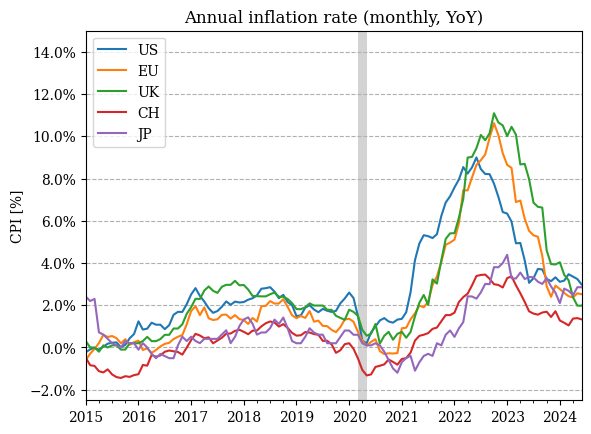

In [59]:
fig, ax = plt.subplots()

df_us["cpi"].pct_change(periods=12).plot(ax=ax, label="US")
df_eu["cpi"].pct_change(periods=12).plot(ax=ax, label="EU")
df_uk["cpi"].pct_change(periods=12).plot(ax=ax, label="UK")
df_ch["cpi"].pct_change(periods=12).plot(ax=ax, label="CH")
df_jp["cpi"].pct_change(periods=12).plot(ax=ax, label="JP")

plot_recessions(ax)

ax.set_xlim(["2015", "2024-06"])
ax.set_ylim([-0.025, 0.15])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which="major", axis="y", linestyle="--")  #  or bothdd
ax.set_title("Annual inflation rate (monthly, YoY)")
ax.set_xlabel("")
ax.set_ylabel("CPI [%]")
ax.legend()
fig.savefig(f"{PLOTS_PATH}/inflation.eps", bbox_inches="tight")
fig.savefig(f"{PLOTS_PATH}/inflation.svg", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


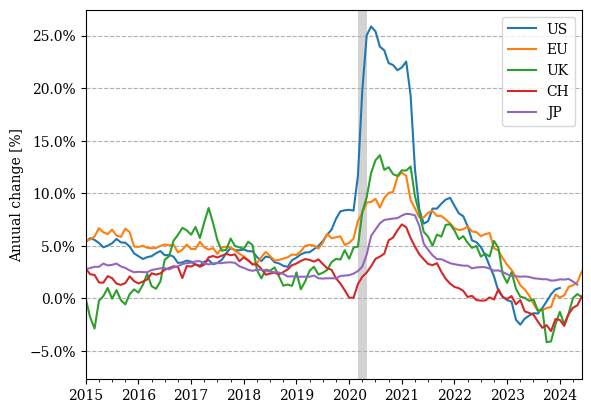

In [60]:
fig, ax = plt.subplots()

df_us["m3"].pct_change(periods=12, fill_method=None).plot(ax=ax, label="US")
df_eu["m3"].pct_change(periods=12, fill_method=None).plot(ax=ax, label="EU")
df_uk["m3"].pct_change(periods=12, fill_method=None).plot(ax=ax, label="UK")
df_ch["m3"].pct_change(periods=12, fill_method=None).plot(ax=ax, label="CH")
df_jp["m3"].pct_change(periods=12, fill_method=None).plot(ax=ax, label="JP")
plot_recessions(ax)

ax.set_xlim(["2015", "2024-06"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which="major", axis="y", linestyle="--")  #  or bothdd
ax.set_xlabel("")
ax.set_ylabel("Anuual change [%]")
# ax.set_title('Cambios en la oferta de dinero para diferentes áreas monetarias');
ax.legend()
fig.savefig(f"{PLOTS_PATH}/money-supply.eps", bbox_inches="tight")
fig.savefig(f"{PLOTS_PATH}/money-supply.svg", bbox_inches="tight")

## Money velocity growth analysis

### Hypothesis test

$H_0$: Mean value of $\Delta\log(v_t)$ is zero.

Null hypothesis is rejected with a significance level of 99%.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


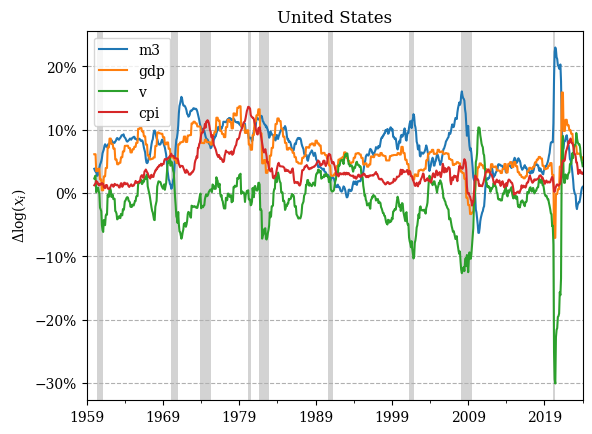

In [61]:
df = df_us
region: Literal["us", "eu", "ch", "uk", "jp"] = "us"

df_deltaLog = df[["m3", "gdp", "v", "cpi"]].dropna().apply(np.log).diff(periods=12).join(df["recession"])

regions: dict[str, str] = {
    "us": "United States",
    "eu": "Euro area",
    "ch": "Switzerland",
    "uk": "United Kingdom",
    "jp": "Japan",
}

fig, ax = plt.subplots()
df_deltaLog[["m3", "gdp", "v", "cpi"]].plot(ax=ax)
plot_recessions(ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which="major", axis="y", linestyle="--")  #  or both
ax.set_xlabel("")
ax.set_ylabel(r"$\Delta\log(x_i)$")
ax.set_title(regions[region])

fig.savefig(f"{PLOTS_PATH}/magnitudes-{region}.eps", bbox_inches="tight")
fig.savefig(f"{PLOTS_PATH}/magnitudes-{region}.svg", bbox_inches="tight")

In [62]:
from scipy.stats import t

mu_0 = 0
mean_yi = df_deltaLog["v"].mean()
sm_yi = df_deltaLog["v"].std()
T = df_deltaLog["v"].count()  #  Excluye valores N/A
sm_medias = sm_yi / np.sqrt(T)

t_score = (mean_yi - mu_0) / sm_medias
p_value = 2 * t.sf(np.abs(t_score), T - 1)
print(f"p-value: {p_value:.5f}")
# Se rechaza H0: mu0=0 al 99%

print(f"mu = {mean_yi * 100:.2f}%")
print(f"mu = {df_deltaLog.loc[:'2019-12-31', 'v'].mean() * 100:.2f}% (hasta 2019.IV)")

print(f"std = {sm_yi * 100:.2f}%")
print(f"std = {df_deltaLog.loc[:'2019-12-31', 'v'].std() * 100:.2f}% (hasta 2019.IV)")

p-value: 0.00000
mu = -0.87%
mu = -0.81% (hasta 2019.IV)
std = 4.56%
std = 3.56% (hasta 2019.IV)


In [63]:
# %% Augmented Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_deltaLog["v"].dropna(), regression="c", autolag="AIC")
print("Augmented Dickey-Fuller")
print(f"\tADF statistic: {result[0]}")
print(f"\tp-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey-Fuller
	ADF statistic: -4.54382796492125
	p-value: 0.00016372963322036524
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [64]:
from statsmodels.tsa.stattools import kpss

result = kpss(df_deltaLog["v"].dropna(), regression="c", nlags="auto")
print("KPSS")
print(f"\tKPSS statistic: {result[0]}")
print(f"\tp-value: {result[1]}")
print("Critical Values:")
for key, value in result[3].items():
    print("\t%s: %.3f" % (key, value))

KPSS
	KPSS statistic: 0.08062980857284893
	p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_10026/119969834.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df_deltaLog["v"].dropna(), regression="c", nlags="auto")


### Markov switching model

$\Delta\log v_t = \mu_{S_t} + \beta d_\text{recession} + \varepsilon_t$

$\varepsilon_t \sim N(0, \sigma^2)$

$S_t\in \{0,1\}$

$P(S_t=s_t|S_{t-1}=s_{t-1})=
\begin{bmatrix}
  p_{00} & p_{10}\\
  1-p_{00} & 1-p_{10}
\end{bmatrix}$

$p_ij$ is the probability of transitioning from regime $i$ to regime $j$.

References:
- Reference: https://stackoverflow.com/questions/42796743/python-statsmodel-tsa-markovautoregression-using-current-real-gnp-gdp-data
- Reference: https://nbviewer.org/gist/ChadFulton/a5d24d32ba3b7b2e381e43a232342f1f
- statsmodels: https://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_autoregression.MarkovAutoregression.html
- statsmodels: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html
- statsmodels: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html
- mswitch (Stata): https://www.stata.com/manuals14/tsmswitch.pdf


In [120]:
import statsmodels.api as sm


df = df_deltaLog.dropna()
y = df["v"].astype(float)
X = df[["recession"]].astype(float)

max_lags = 3

for i in range(1, max_lags + 1):
    X[f"recession_lag_{i}"] = df["recession"].shift(i)

y = y[max_lags:]
X = X.iloc[max_lags:]

# X = sm.add_constant(X) # Not to be included if the option trend='c' is specified at MarkovRegression

model = sm.tsa.MarkovRegression(
    y,
    k_regimes=2,
    exog=X,
    switching_exog=False,
    # switching_trend=False,
    trend="c",
)
res = model.fit()

print(f"Estimated duration: {res.expected_durations}")
res.summary()

Estimated duration: [39.77090698 31.76124223]


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      v   No. Observations:                  766
Model:               MarkovRegression   Log Likelihood                1502.345
Date:                Fri, 06 Jun 2025   AIC                          -2986.689
Time:                        10:16:21   BIC                          -2944.918
Sample:                    04-01-1960   HQIC                         -2970.610
                         - 01-01-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0241      0.002     10.668      0.000       0.020       0.028
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0343      0.002    -14.254      0.000      -0.039      -0.030
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0026      0.008     -0.317      0.751      -0.019       0.013
x2            -0.0186      0.011     -1.718      0.086      -0.040       0.003
x3            -0.0123      0.011     -1.140      0.254      -0.033       0.009
x4            -0.0142      0.008     -1.788      0.074      -0.030       0.001
sigma2         0.0010   5.26e-05     19.136      0.000       0.001       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9749      0.008    120.270      0.000       0.959       0.991
p[1->0]        0.0315      0.010      3.262      0.001       0.013       0.050
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [121]:
y_hat = res.predict()
y_mean = y.mean()

sst = ((y - y_mean) ** 2).sum()
sse = ((y - y_hat) ** 2).sum()
ssr = ((y_hat - y_mean) ** 2).sum()
r2 = 1 - sse / sst

print(f"R^2 = {r2:.4f}")

print(f"SST = {sst:.4f}")
print(f"SSE = {sse:.4f}")
print(f"SSR = {ssr:.4f}")

R^2 = 0.5685
SST = 1.5909
SSE = 0.6864
SSR = 0.7338


In [122]:
res.params.map("{:,.3f}".format) + res.pvalues.map(" ({:,.3f})".format)

print("Numerical values:")
params = ["const[0]", "const[1]", "x1[1]", "p[0->0]", "p[1->0]"]
for param in params:
    print(f"{res.params[param]:.3f}\n({res.pvalues[param]:.3f})")
print(f"{r2:.3f}")

Numerical values:
0.024
(0.000)
-0.034
(0.000)
-0.003
(0.751)
0.975
(0.000)
0.031
(0.001)
0.569


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R^2 = 0.5685


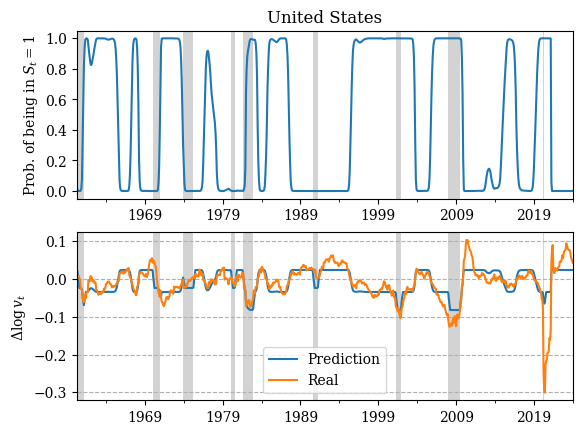

In [123]:
fig, ax = plt.subplots(2)
ax[0].set_title(regions[region])
res.smoothed_marginal_probabilities[1].plot(
    ylabel="Prob. of being in $S_t=1$", ax=ax[0]
)
plot_recessions(ax[0])
ax[0].set_xlabel("")

y_hat.plot(ax=ax[1], label="Prediction")
y.plot(ax=ax[1], label="Real")
plot_recessions(ax[1])

ax[1].grid(which="major", axis="y", linestyle="--")  #  or both
ax[1].set_xlabel("")
ax[1].set_ylabel(r"$\Delta\log v_t$")
ax[1].legend()

fig.savefig(f"{PLOTS_PATH}/markov-v-{region}.eps", bbox_inches="tight")
fig.savefig(f"{PLOTS_PATH}/markov-v-{region}.svg", bbox_inches="tight")
print(f"R^2 = {r2:.4f}")

## Inflation switching model

In [127]:
y = df_deltaLog.dropna()["cpi"].astype(float)
X = df_deltaLog.dropna()[["v", "m3"]].astype(float)

max_lags = 2

for i in range(1, max_lags + 1):
    X[f"v_lag_{i}"] = X["v"].shift(i)

for i in range(1, max_lags + 1):
    X[f"m3_lag_{i}"] = X["m3"].shift(i)

y = y[max_lags:]
X = X.iloc[max_lags:]
# X.drop('v', axis=1, inplace=True)

model = sm.tsa.MarkovRegression(
    y,
    k_regimes=2,
    exog=X,
    # switching_exog={'v': False, 'm3': True},
    switching_exog=[False] * (max_lags + 1) + [True] * (max_lags + 1),
    # switching_trend=False,
    trend="c",
)
res = model.fit()

print(f"Estimated duration: {res.expected_durations}")
res.summary()

Estimated duration: [103.48556016  28.99853662]


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    cpi   No. Observations:                  767
Model:               MarkovRegression   Log Likelihood                2247.215
Date:                Fri, 06 Jun 2025   AIC                          -4466.429
Time:                        10:16:57   BIC                          -4401.434
Sample:                    03-01-1960   HQIC                         -4441.412
                         - 01-01-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.229      0.819      -0.003       0.003
x4             0.1401      0.055      2.552      0.011       0.033       0.248
x5             0.2469      0.201      1.230      0.219      -0.147       0.640
x6             0.0540      0.126      0.429      0.668      -0.193       0.301
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0204      0.003      6.044      0.000       0.014       0.027
x4             0.1299      0.075      1.743      0.081      -0.016       0.276
x5             0.0024      0.244      0.010      0.992      -0.476       0.481
x6             0.6332      0.188      3.377      0.001       0.266       1.001
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1714      0.056      3.079      0.002       0.062       0.281
x2             0.1591      0.125      1.275      0.202      -0.085       0.404
x3             0.0861      0.074      1.170      0.242      -0.058       0.230
sigma2         0.0002   7.75e-06     19.375      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9903      0.004    251.016      0.000       0.983       0.998
p[1->0]        0.0345      0.015      2.346      0.019       0.006       0.063
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [128]:
y_hat = res.predict()
y_mean = y.mean()

sst = ((y - y_mean) ** 2).sum()
sse = ((y - y_hat) ** 2).sum()
ssr = ((y_hat - y_mean) ** 2).sum()
r2 = 1 - sse / sst

print(f"R^2 = {r2:.4f}")

print(f"SST = {sst:.4f}")
print(f"SSE = {sse:.4f}")
print(f"SSR = {ssr:.4f}")

R^2 = 0.8104
SST = 0.5466
SSE = 0.1036
SSR = 0.4200


In [129]:
# print(res.params.map('{:,.3f}'.format) + res.pvalues.map(' ({:,.3f})'.format))

print("Numerical values:")
params = [
    "const[0]",
    "x4[0]",
    "x5[0]",
    "x6[0]",
    "const[1]",
    "x4[1]",
    "x5[1]",
    "x6[1]",
    "x1[1]",
    "x2[1]",
    "x3[1]",
    "p[0->0]",
    "p[1->0]",
]
for param in params:
    print(f"{res.params[param]:.3f}\n({res.pvalues[param]:.3f})")
print(f"{r2:.3f}")

Numerical values:
-0.000
(0.819)
0.140
(0.011)
0.247
(0.219)
0.054
(0.668)
0.020
(0.000)
0.130
(0.081)
0.002
(0.992)
0.633
(0.001)
0.171
(0.002)
0.159
(0.202)
0.086
(0.242)
0.990
(0.000)
0.034
(0.019)
0.810


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R^2 = 0.8104


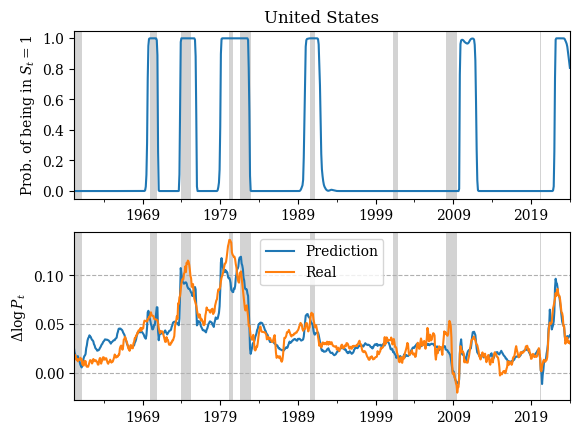

In [130]:
fig, ax = plt.subplots(2)
ax[0].set_title(regions[region])
res.smoothed_marginal_probabilities[1].plot(
    ylabel="Prob. of being in $S_t=1$", ax=ax[0]
)
plot_recessions(ax[0])
ax[0].set_xlabel("")

y_hat.plot(ax=ax[1], label="Prediction")
y.plot(ax=ax[1], label="Real")
plot_recessions(ax[1])

ax[1].grid(which="major", axis="y", linestyle="--")  #  or both
ax[1].set_xlabel("")
ax[1].set_ylabel(r"$\Delta\log P_t$")
ax[1].legend()

fig.savefig(f"{PLOTS_PATH}/markov-cpi-{region}.eps", bbox_inches="tight")
fig.savefig(f"{PLOTS_PATH}/markov-cpi-{region}.svg", bbox_inches="tight")
print(f"R^2 = {r2:.4f}")